# VS associations with cognitive performance (P) with an interaction with DRD2 polymorphism

***

## Distributions

In [87]:
import matplotlib.pyplot as plt
import ptitprince as pt
import pandas as pd
from scipy import stats
from statsmodels.compat import unicode
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from IPython.core.display import HTML

In [8]:
# Loading data
data = pd.read_csv('DRD2_subset_data.csv', delimiter=',')
data = data.dropna(subset=['P','Q','VS','DRD2', 'AGE', 'female_1'])

#### Age Distribution

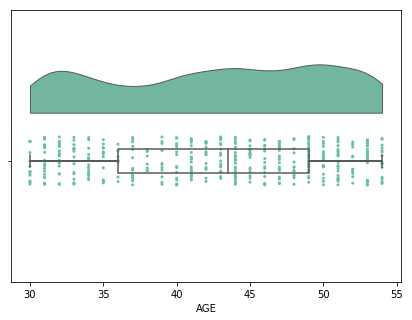

In [50]:
age_plot = pt.RainCloud(y='AGE', orient='h',data=data, width_viol=.4, width_box=.1, figsize=(7,5))

#### Sex Distribution (Female == 1)

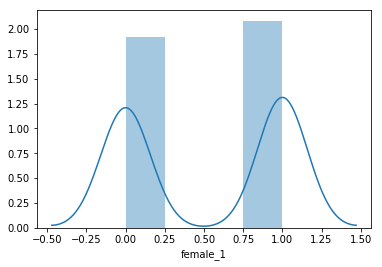

In [66]:
sex_plot = sns.distplot(data["female_1"])

#### IGT Score Distrbutions (P and Q)

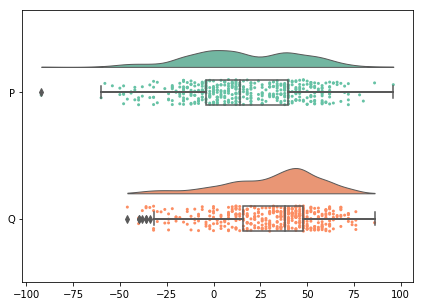

In [69]:
IGT_raincloud = pt.RainCloud(data=data.iloc[:,2:4], orient='h', width_viol=.4, width_box=.2, figsize=(7,5))

#### Ventral Striatum Reactivity (VS)

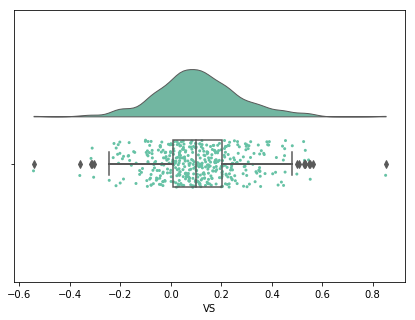

In [70]:
VS_raincloud = pt.RainCloud(y='VS', data=data, orient='h', width_viol=.4, width_box=.2, figsize=(7,5))

#### DRD2 Polymorphism

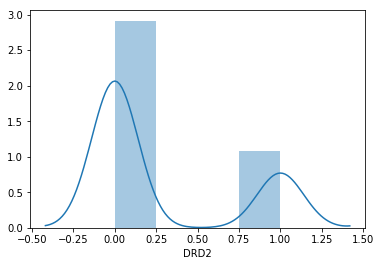

In [72]:
sex_plot = sns.distplot(data["DRD2"])

***


# T-Tests

In [ ]:
# Splitting data based on DRD2 polymorphism
low = data[data['DRD2'] == 1] # Low D2 Receptors
normal = data[data['DRD2'] == 0] # Normal D2 Receptors

### T-Test between DRD2 vs P and Q

In [91]:
t_test_results = stats.ttest_ind(low.iloc[:,2:5], normal.iloc[:,2:5], equal_var=True)
cols = ['P', 'Q', 'VS']
pd.DataFrame({'Statistics':t_test_results.statistic[0:], 'P-values':t_test_results.pvalue}, cols)

,Statistics,P-values
P,-3.230837,0.001328
Q,0.539049,0.590128
VS,-1.771730,0.077138


### P vs VS between DRD2 groups

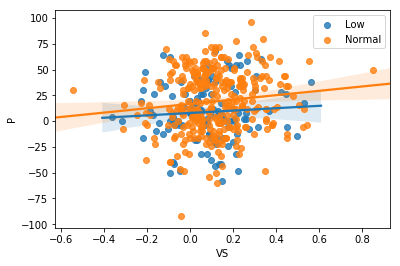

In [89]:
scatter_P_low = sns.regplot(x='VS', y='P', data=low, label='Low').legend()
scatter_P_normal = sns.regplot(x='VS', y='P', data=normal, label='Normal').legend()

### Q vs VS between DRD2 groups

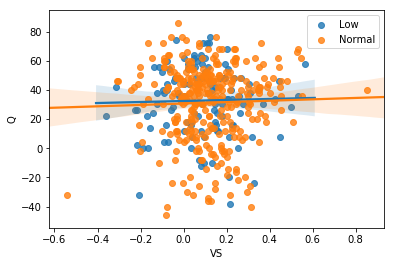

In [82]:
low = data[data['DRD2'] == 1] #Low D2 Receptors
normal = data[data['DRD2'] == 0] #Normal D2 Receptors
scatter_P_low = sns.regplot(x='VS', y='Q', data=low, label='Low').legend()
scatter_P_normal = sns.regplot(x='VS', y='Q', data=normal, label='Normal').legend()

*****


# Linear Regression

## P ~ DRD2 + VS + DRD2 * VS

In [78]:
target = pd.DataFrame(data.P, columns=['P'])
x = pd.DataFrame(data, columns=['DRD2','VS'])
y = target['P']
results = smf.ols(formula='P ~ DRD2 + VS + DRD2 * VS',data=data).fit()
HTML(results.summary().tables[1].as_html())

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,16.7039,2.020,8.269,0.000,12.733,20.674
DRD2,-8.7905,3.634,-2.419,0.016,-15.932,-1.649
VS,21.1400,10.020,2.110,0.035,1.447,40.833
DRD2:VS,-9.5730,18.830,-0.508,0.611,-46.582,27.436


## Q ~ DRD2 + VS + DRD2 * VS

In [79]:
target = pd.DataFrame(data.P, columns=['Q'])
x = pd.DataFrame(data, columns=['DRD2','VS'])
y = target['Q']
results = smf.ols(formula='Q ~ DRD2 + VS + DRD2 * VS',data=data).fit()
HTML(results.summary().tables[1].as_html())

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,30.6606,1.746,17.563,0.000,27.230,34.092
DRD2,1.7348,3.140,0.553,0.581,-4.437,7.906
VS,4.7830,8.658,0.552,0.581,-12.234,21.801
DRD2:VS,-1.3082,16.272,-0.080,0.936,-33.289,30.673
